## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Colab Notebook 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [1]:
# Check the GPU
!nvidia-smi

Tue Aug 15 14:33:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install dependencies.
!pip install xformers bitsandbytes transformers accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.3 MB/s eta 0:00:00


Make sure to install `diffusers` from `main`.

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download `diffusers` SDXL DreamBooth training script.

In [4]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2023-08-15 14:34:16--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57305 (56K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  55.96K  --.-KB/s    in 0.01s   

2023-08-15 14:34:16 (5.05 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [57305/57305]



## Dataset 🐶

Let's download some example images:

In [ ]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/content/dog'

Preview the images:

In [6]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

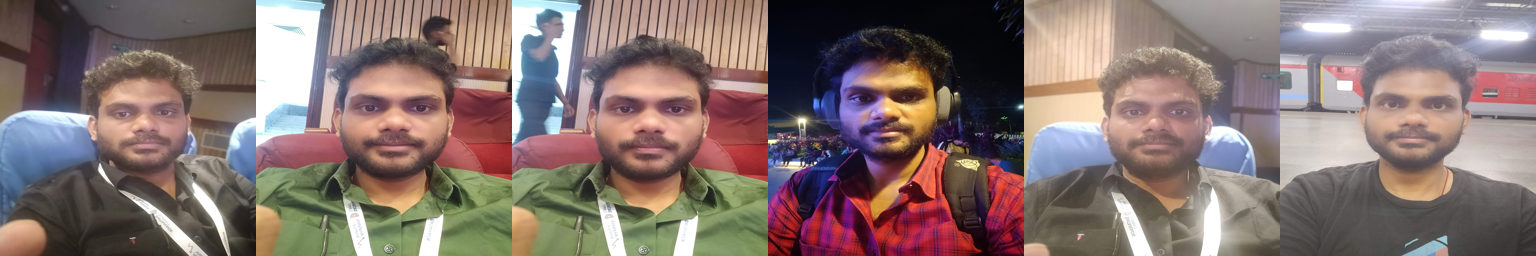

In [10]:
import glob

imgs = [Image.open(path) for path in glob.glob("./dinesh/*.jpg")]
image_grid(imgs, 1, 6)

## Prep for training 💻

Initialize `accelerate`:

In [9]:
!accelerate config default

2023-08-15 14:35:45.837815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


Make sure to log into [your Hugging Face account](https://huggingface.co/) and pass [your access token](https://huggingface.co/docs/hub/security-tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [12]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /roo

## Train! 🔬

Alright let's launch a training. Make sure to add `push_to_hub` so that the checkpoint is automatically pushed to the Hub and doesn't get lost.

To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* Memory-efficient attention (`--enable_xformers_memory_efficient_attention`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

The `--push_to_hub` argument ensures that the trained checkpoints are automatically pushed to the Hugging Face Hub.

In [13]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="dinesh" \
  --output_dir="lora-trained-xl-dinesh" \
  --mixed_precision="fp16" \
  --instance_prompt="a photo of dinesh" \
  --resolution=1024 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --enable_xformers_memory_efficient_attention \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0" \
  --push_to_hub

2023-08-15 14:39:09.042083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-15 14:39:15.281639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
08/15/2023 14:39:17 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'dynamic_thresholding_ratio', 'clip_sample_range', 'thresholding', 'variance_type'} was not found in config. Values will be initialized to default values.
08/15/2023 14:46:21 - INFO - __main__ - ***** Running training *****
08/15/2023 14:46:21 - INFO - __main__ -   Num ex

Cool the model has been uploaded to https://huggingface.co/sayakpaul/lora-trained-xl-colab 🔥🚀

Let's generate some images with it!

## Inference 🐕

In [15]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae, torch_dtype=torch.float16, variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights("DineshKumarSarangapani/lora-trained-xl-dinesh")

_ = pipe.to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

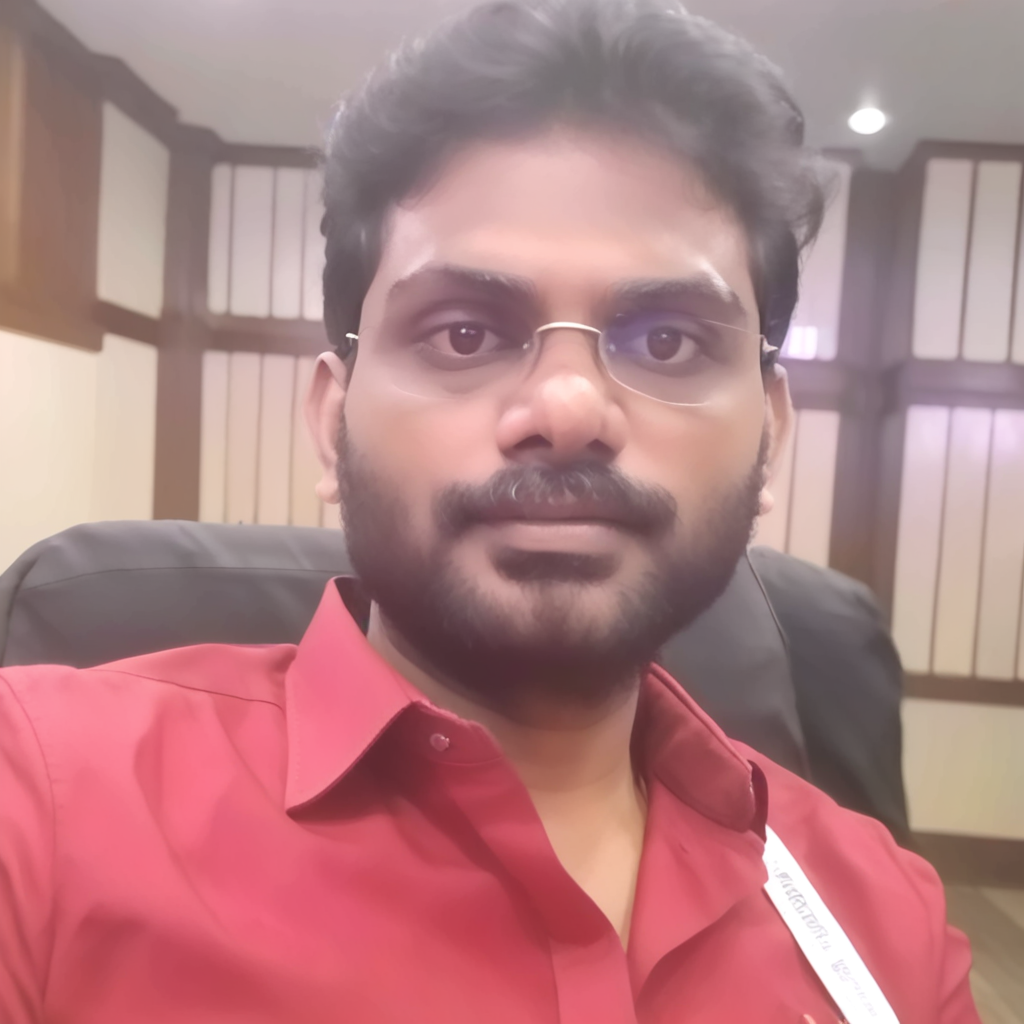

In [16]:
prompt = "a photo of dinesh in red shirt with cooling glass"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

  0%|          | 0/25 [00:00<?, ?it/s]

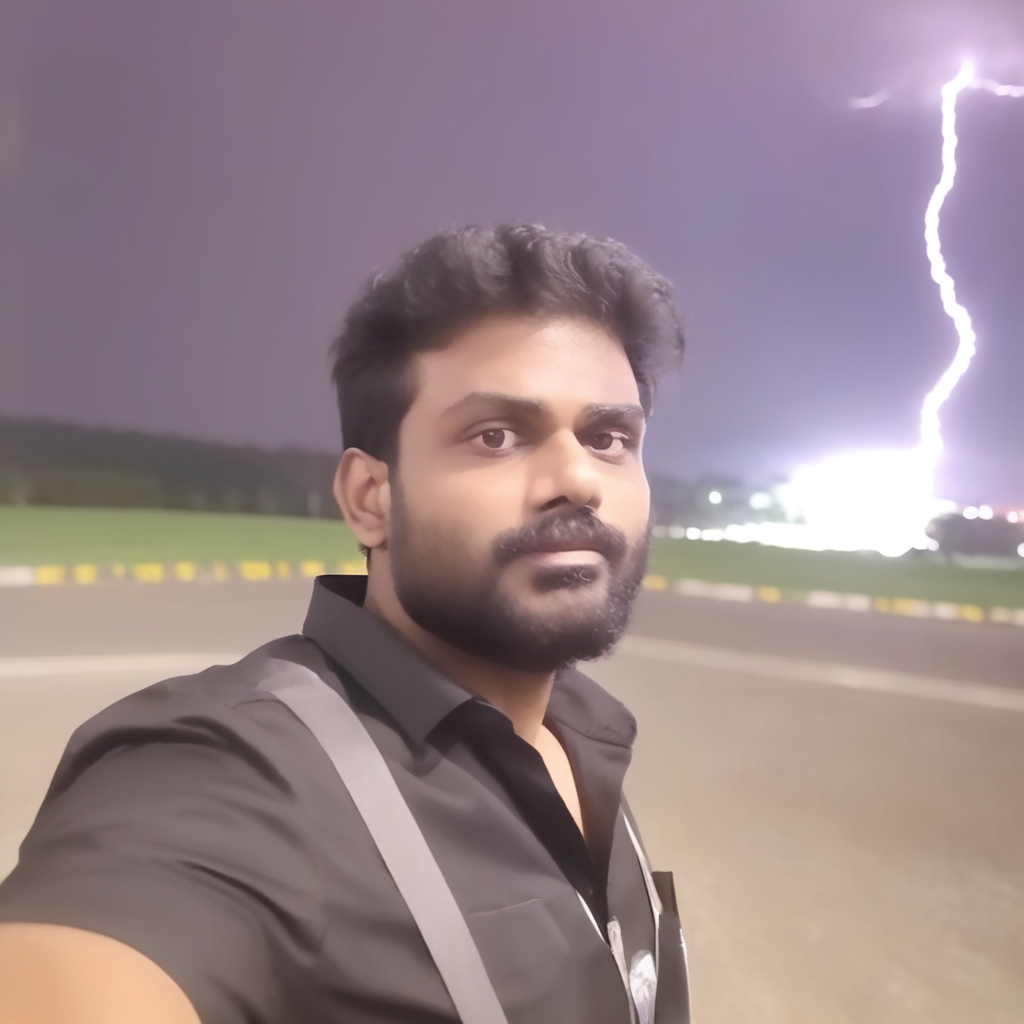

In [17]:
prompt = "a photo of dinesh in black shirt in night with lightning in the background, 8k"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

  0%|          | 0/25 [00:00<?, ?it/s]

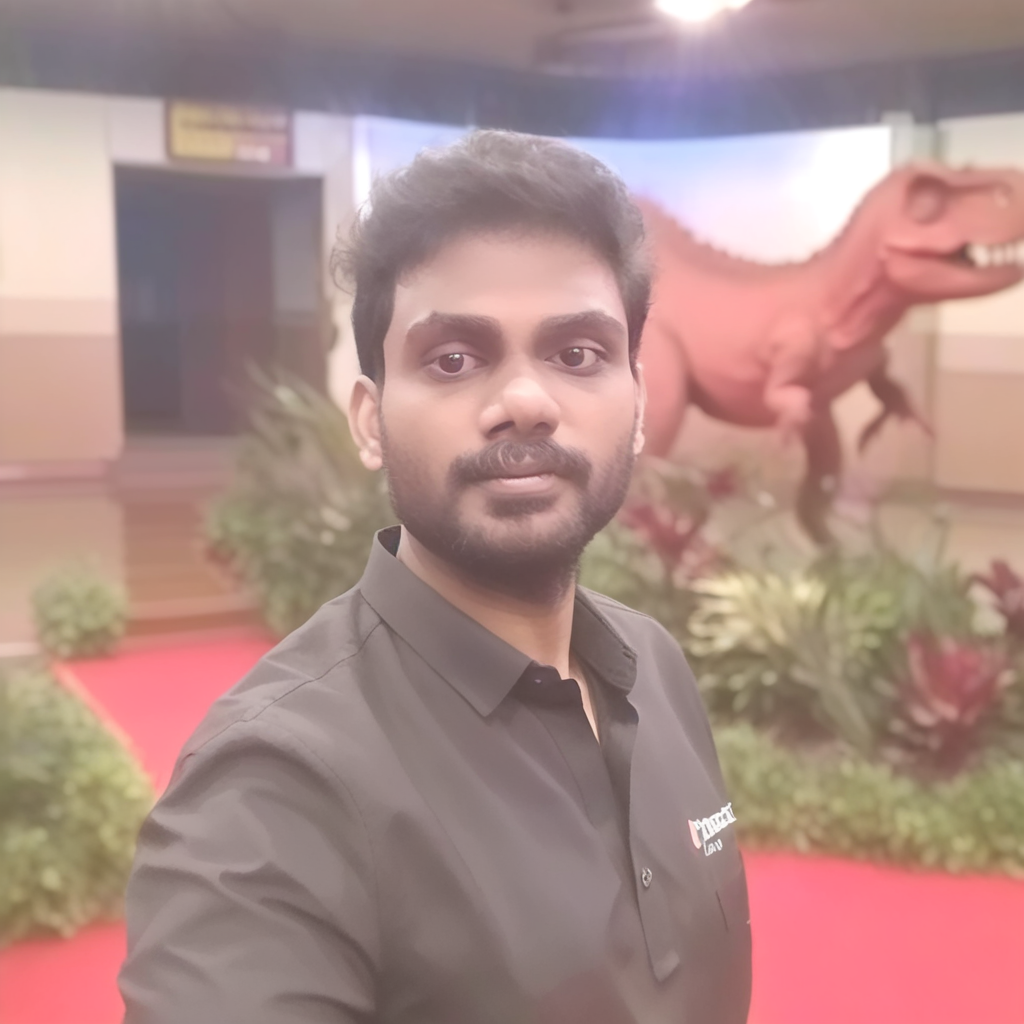

In [19]:
prompt = "a photo of dinesh with dinosours in background"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

  0%|          | 0/25 [00:00<?, ?it/s]

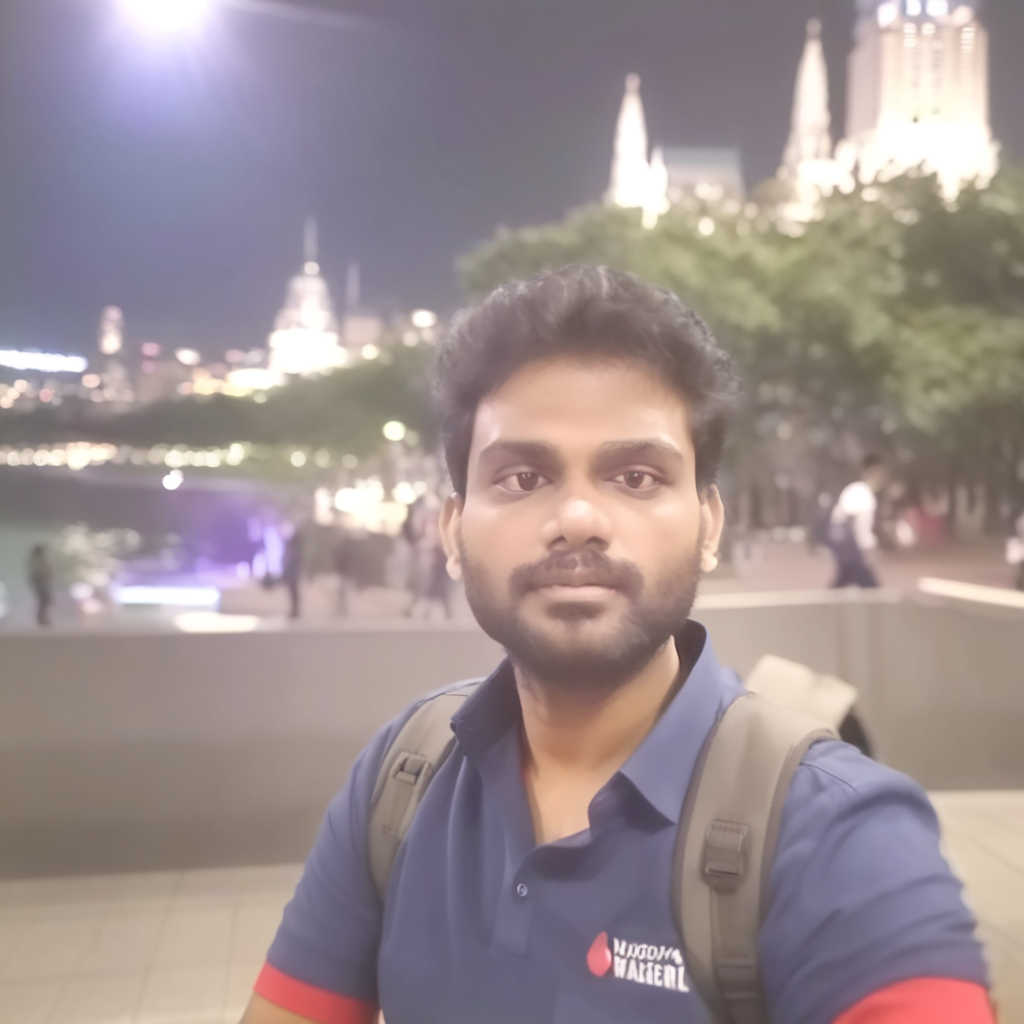

In [20]:
prompt = "a photo of dinesh in newyork city"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

  0%|          | 0/25 [00:00<?, ?it/s]

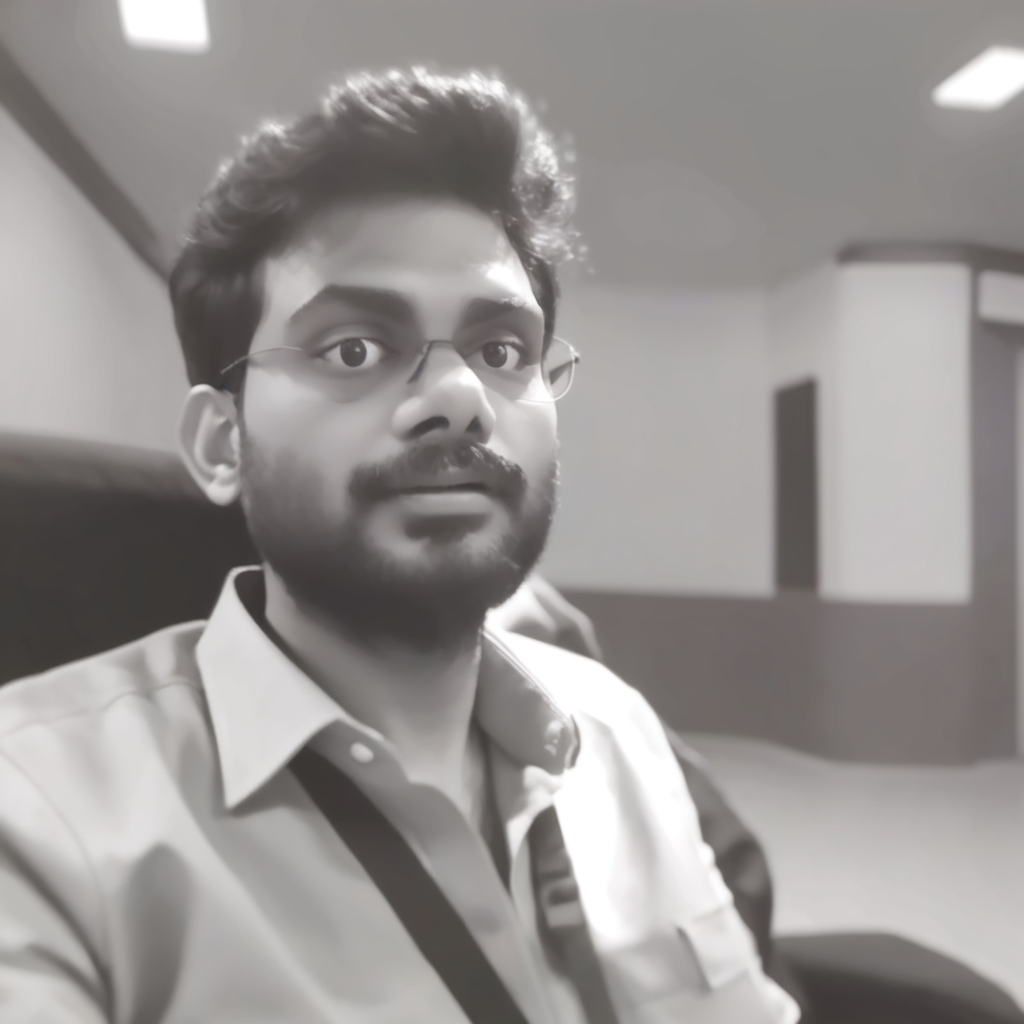

In [21]:
prompt = "a photo of dinesh in pixar style 3d"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

  0%|          | 0/25 [00:00<?, ?it/s]

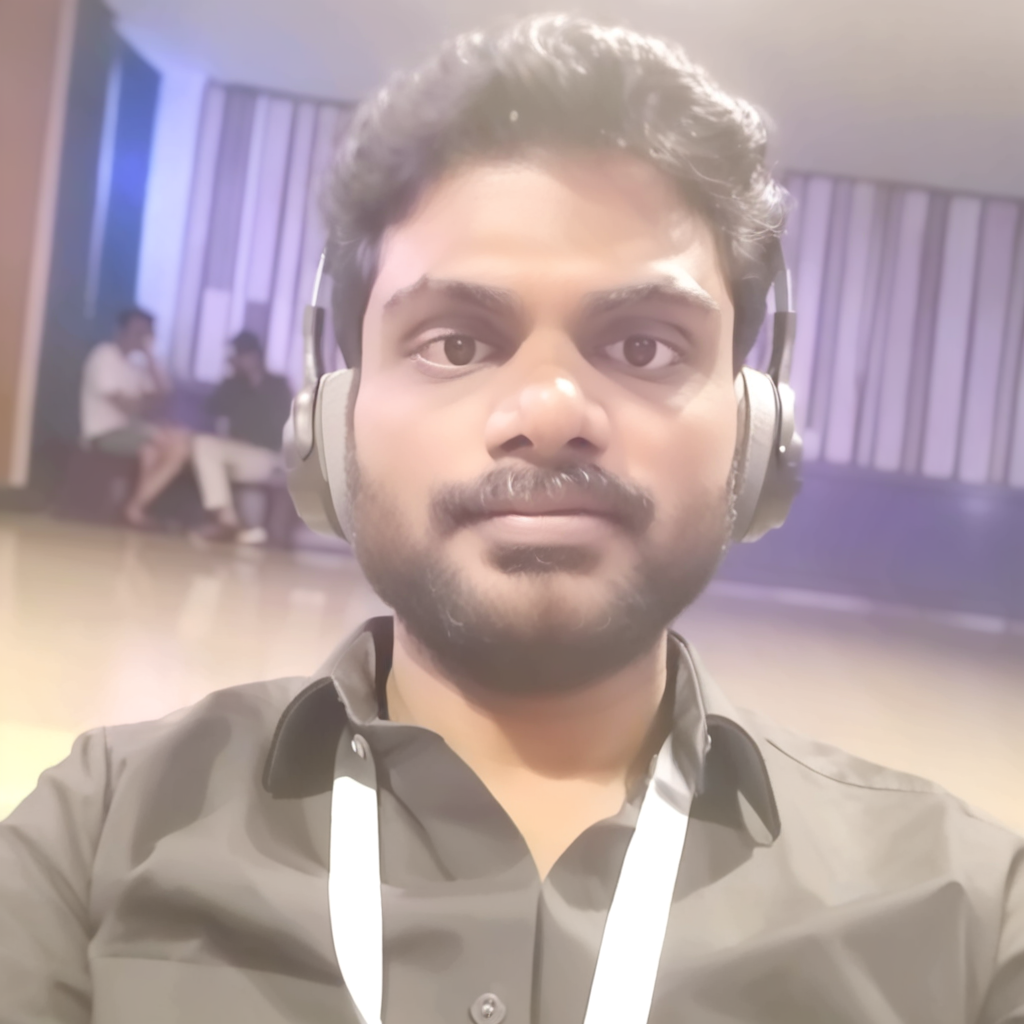

In [22]:
prompt = "a photo of dinesh as a cartoon"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

  0%|          | 0/25 [00:00<?, ?it/s]

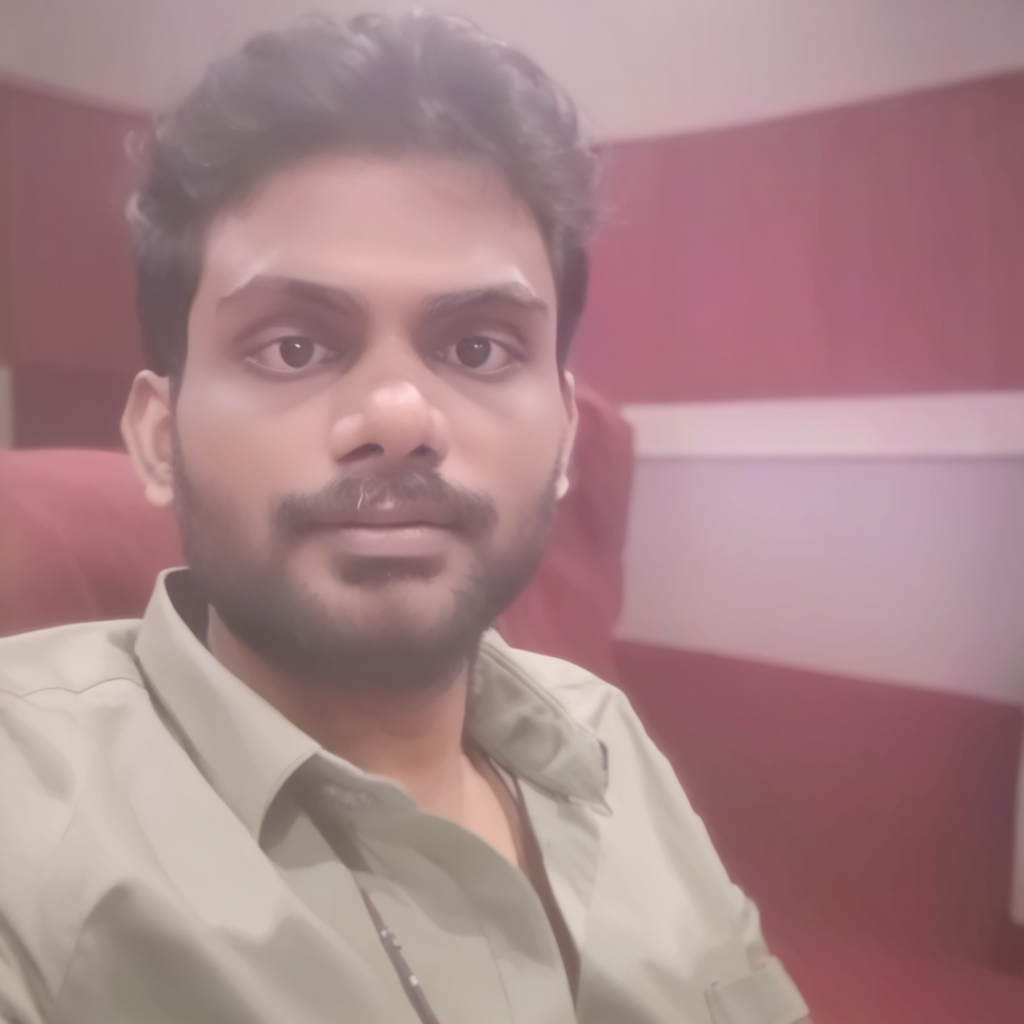

In [23]:
prompt = "a photo of dinesh as an anime"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image